<a href="https://colab.research.google.com/github/UN-GCPDS/python-gcpds.EEG_Tensorflow_models/blob/main/Experimental/DW_LCAM/%5B2%5D_Main_DWCNN_BN_MI_Giga_1conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**LOAD SUPPORTING MODULES**

In [ ]:
#-------------------------------------------------------------------------------
import numpy as np
import scipy.io as sio
import pywt
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import math
import shutil
import pickle
import os
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,cohen_kappa_score,mean_squared_error
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
from datetime import date, datetime
from scipy.stats import kurtosis, skew
from sklearn.model_selection import ShuffleSplit
#-------------------------------------------------------------------------------

**DEFINE CUSTOM FUNCTIONS TO USE**
- We design four custom functions: i) load data acroos time windows, ii) normalization function, iii) function to build the CNN network, and iv) a function to compute kappa score manually.

In [ ]:
#-------------------------------------------------------------------------------
def TW_data(sbj,time_inf,time_sup):
    # Load data/images----------------------------------------------------------
    path_cwt = '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/data/CWT_CSP_data_mubeta_8_30_Tw_'+str(time_inf)+'s_'+str(time_sup)+'s_subject'+str(sbj)+'_cwt_resized_10.pickle'  
    with open(path_cwt, 'rb') as f:
         X_train_re_cwt, X_test_re_cwt, y_train, y_test = pickle.load(f)
    path_csp = '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/data/CWT_CSP_data_mubeta_8_30_Tw_'+str(time_inf)+'s_'+str(time_sup)+'s_subject'+str(sbj)+'_csp_resized_10.pickle'  
    with open(path_csp, 'rb') as f:
         X_train_re_csp, X_test_re_csp, y_train, y_test = pickle.load(f)
    #---------------------------------------------------------------------------
    return X_train_re_cwt, X_train_re_csp, X_test_re_cwt, X_test_re_csp, y_train, y_test
#-------------------------------------------------------------------------------
def norm_data(XF_train_cwt, XF_train_csp, XF_test_cwt, XF_test_csp, n_fb, Ntw, y_train, y_test, fld):
    # orden de las inputs:------------------------------------------------------
    # [CWT_fb1_TW1, CWT_fb2_TW1 --- CWT_fb1_TW2, CWT_fb2_TW2 --- CWT_fb1_TWN, CWT_fb2_TWN] ... [CSP]
    #---------------------------------------------------------------------------
    XT_train_csp = []
    XT_valid_csp = []
    XT_test_csp  = []
    XT_train_cwt = []
    XT_valid_cwt = []
    XT_test_cwt  = []
    for tw in range(Ntw):
        for fb in range(n_fb):
            X_train_cwt, X_test_cwt = XF_train_cwt[tw][:,fb,:,:].astype(np.uint8), XF_test_cwt[tw][:,fb,:,:].astype(np.uint8)
            X_train_csp, X_test_csp = XF_train_csp[tw][:,fb,:,:].astype(np.uint8), XF_test_csp[tw][:,fb,:,:].astype(np.uint8)
            #-------------------------------------------------------------------
            # train/validation data split
            rs = ShuffleSplit(n_splits=1, test_size=.1, random_state=fld)
            for train_index, valid_index in rs.split(X_train_cwt):
              X_train_cwtf = X_train_cwt[train_index,:,:] # cwt
              X_valid_cwtf = X_train_cwt[valid_index,:,:]
              X_train_cspf = X_train_csp[train_index,:,:] # csp
              X_valid_cspf = X_train_csp[valid_index,:,:]
            #-------------------------------------------------------------------          
            # Normalize data----------------------------------------------------
            X_mean_cwt  = X_train_cwtf.mean(axis=0, keepdims=True)
            X_std_cwt   = X_train_cwtf.std(axis=0, keepdims=True) + 1e-7
            X_train_cwt = (X_train_cwtf - X_mean_cwt) / X_std_cwt
            X_valid_cwt = (X_valid_cwtf - X_mean_cwt) / X_std_cwt
            X_test_cwt  = (X_test_cwt  - X_mean_cwt) / X_std_cwt

            X_mean_csp  = X_train_cspf.mean(axis=0, keepdims=True)
            X_std_csp   = X_train_cspf.std(axis=0, keepdims=True) + 1e-7
            X_train_csp = (X_train_cspf - X_mean_csp) / X_std_csp
            X_valid_csp = (X_valid_cspf - X_mean_csp) / X_std_csp
            X_test_csp  = (X_test_csp  - X_mean_csp) / X_std_csp
            #-------------------------------------------------------------------
            # set new axis------------------------------------------------------
            X_train_cwt = X_train_cwt[..., np.newaxis]
            X_valid_cwt = X_valid_cwt[..., np.newaxis]
            X_test_cwt  = X_test_cwt[..., np.newaxis]   
            XT_train_cwt.append(X_train_cwt)
            XT_valid_cwt.append(X_valid_cwt)
            XT_test_cwt.append(X_test_cwt)
                                
            X_train_csp = X_train_csp[..., np.newaxis]
            X_valid_csp = X_valid_csp[..., np.newaxis]
            X_test_csp  = X_test_csp[..., np.newaxis]   
            XT_train_csp.append(X_train_csp)
            XT_valid_csp.append(X_valid_csp)
            XT_test_csp.append(X_test_csp)
            #-------------------------------------------------------------------
    y_trainf = y_train[train_index]
    y_validf = y_train[valid_index]
    y_trainF, y_validF, y_testF = y_trainf.reshape((-1,))-1, y_validf.reshape((-1,))-1, y_test.reshape((-1,))-1
    #---------------------------------------------------------------------------
    # Convert class vectors to binary class matrices----------------------------
    y_train = keras.utils.to_categorical(y_trainF,num_classes)
    y_valid = keras.utils.to_categorical(y_validF,num_classes)
    y_test  = keras.utils.to_categorical(y_testF,num_classes)
    #---------------------------------------------------------------------------
    XT_train = XT_train_cwt + XT_train_csp
    XT_valid = XT_valid_cwt + XT_valid_csp
    XT_test  = XT_test_cwt  + XT_test_csp
    #---------------------------------------------------------------------------
    return XT_train, XT_valid, XT_test, y_train, y_valid, y_test, train_index, valid_index  
#-------------------------------------------------------------------------------
def cnn_network(n_fb,Nkfeats,Ntw,shape_,n_filt,units,l1p,l2p,lrate,sbj):
    #---------------------------------------------------------------------------
    keras.backend.clear_session()
    np.random.seed(123)
    tf.compat.v1.random.set_random_seed(123)
    #---------------------------------------------------------------------------
    input_  = [None]*Ntw*n_fb*Nkfeats
    conv_   = [None]*Ntw*n_fb*Nkfeats
    pool_   = [None]*Ntw*n_fb*Nkfeats
    batch0_ = [None]*Ntw*n_fb*Nkfeats
    batch2_ = [None]*Ntw*n_fb*Nkfeats
    for i in range(Ntw*n_fb*Nkfeats):
        input_[i]  = keras.layers.Input(shape=[shape_,shape_,1])
        conv_[i]   = keras.layers.Conv2D(filters=n_filt,kernel_size=3,strides=1,activation='relu',padding='SAME',input_shape=[shape_,shape_,1])(input_[i])
        #-----------------------------------------------------------------------
        batch0_[i] = keras.layers.BatchNormalization()(conv_[i])
        #-----------------------------------------------------------------------
        pool_[i]   = keras.layers.MaxPooling2D(pool_size=2)(batch0_[i])
        #-----------------------------------------------------------------------
    concat  = keras.layers.concatenate(pool_)
    flat    = keras.layers.Flatten()(concat)
    #---------------------------------------------------------------------------
    batch1  = keras.layers.BatchNormalization()(flat)
    hidden1 = keras.layers.Dense(units=units,activation='relu',kernel_regularizer=keras.regularizers.l1_l2(l1=l1p, l2=l2p), kernel_constraint=max_norm(1.))(batch1)#
    batch2  = keras.layers.BatchNormalization()(hidden1)
    output  = keras.layers.Dense(units=2, activation='softmax', kernel_constraint=max_norm(1.))(batch2)#
    model   = keras.models.Model(inputs=input_, outputs=[output])
    #---------------------------------------------------------------------------
    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(lrate, 4000, power=1.0,cycle=False, name=None)
    opt     = keras.optimizers.Adam(learning_rate=learning_rate_fn) 
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
    return model
#-------------------------------------------------------------------------------

# CNN-D&W network (1-conv-layer)

**DWCNN TRAINING AND VALIDATION STAGE**




Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


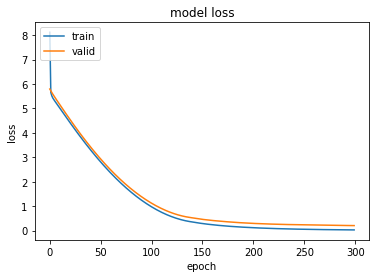

Units_100_l1_0.0005_l2_0.0005
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


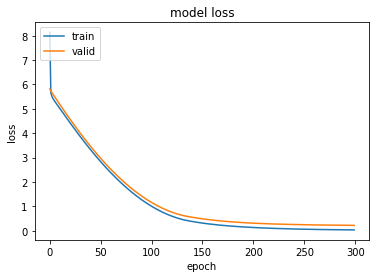

Units_100_l1_0.0005_l2_0.0005
Acc Train: 95.91836734693877
Acc Valid: 81.81818181818181
Acc Test: 53.84615384615385
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


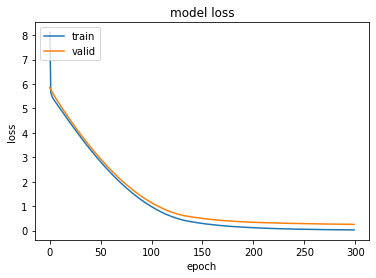

Units_100_l1_0.0005_l2_0.0005
Acc Train: 96.93877551020408
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
AVG Score Train: [97.27891156  0.94552145]
AVG Score Valid: [87.87878788  0.75946425]
AVG Score Test: [58.97435897  0.20060135]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


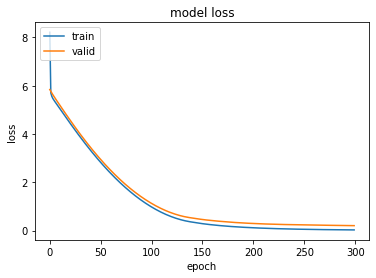

Units_100_l1_0.0005_l2_0.001
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


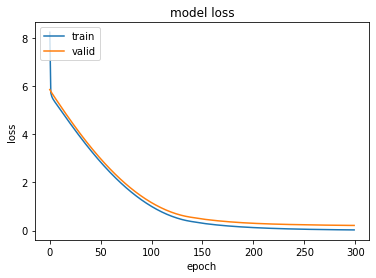

Units_100_l1_0.0005_l2_0.001
Acc Train: 95.91836734693877
Acc Valid: 81.81818181818181
Acc Test: 53.84615384615385
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


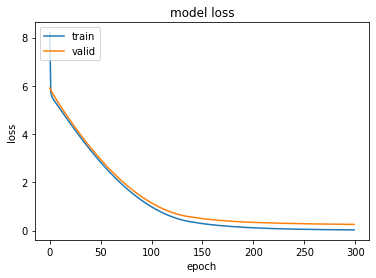

Units_100_l1_0.0005_l2_0.001
Acc Train: 96.93877551020408
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
AVG Score Train: [97.27891156  0.94552145]
AVG Score Valid: [87.87878788  0.75946425]
AVG Score Test: [58.97435897  0.20060135]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


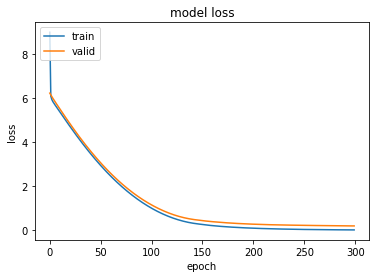

Units_100_l1_0.0005_l2_0.005
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


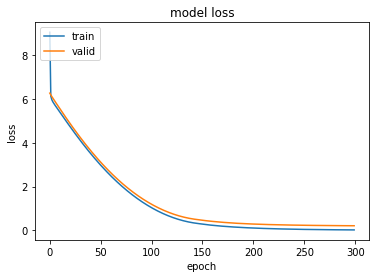

Units_100_l1_0.0005_l2_0.005
Acc Train: 95.91836734693877
Acc Valid: 81.81818181818181
Acc Test: 53.84615384615385
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


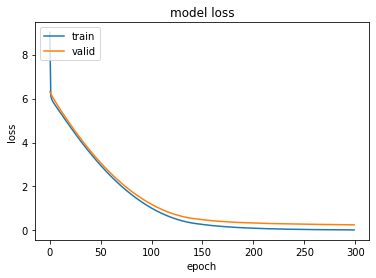

Units_100_l1_0.0005_l2_0.005
Acc Train: 96.93877551020408
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
AVG Score Train: [97.27891156  0.94552145]
AVG Score Valid: [87.87878788  0.75946425]
AVG Score Test: [58.97435897  0.20060135]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


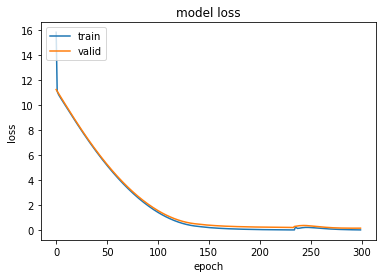

Units_100_l1_0.001_l2_0.0005
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


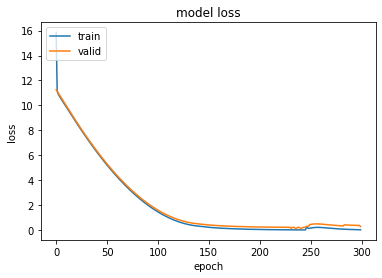

Units_100_l1_0.001_l2_0.0005
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 53.84615384615385
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


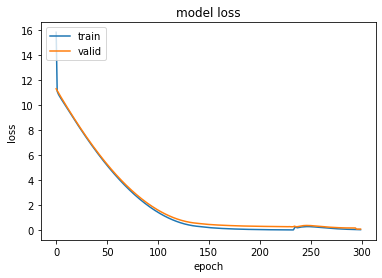

Units_100_l1_0.001_l2_0.0005
Acc Train: 100.0
Acc Valid: 100.0
Acc Test: 76.92307692307692
AVG Score Train: [99.31972789  0.98638889]
AVG Score Valid: [93.93939394  0.87570621]
AVG Score Test: [64.1025641   0.29670232]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


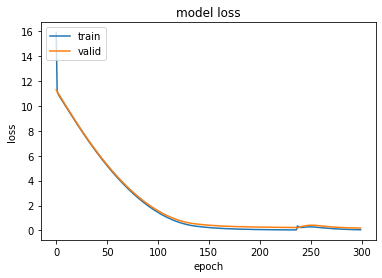

Units_100_l1_0.001_l2_0.001
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


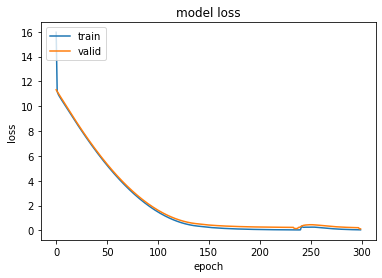

Units_100_l1_0.001_l2_0.001
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 53.84615384615385
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


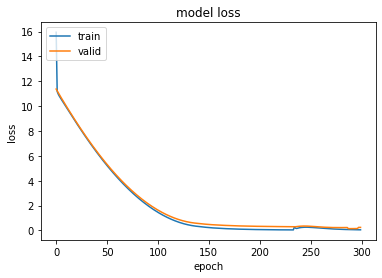

Units_100_l1_0.001_l2_0.001
Acc Train: 92.85714285714286
Acc Valid: 100.0
Acc Test: 76.92307692307692
AVG Score Train: [96.93877551  0.93876984]
AVG Score Valid: [93.93939394  0.87570621]
AVG Score Test: [64.1025641   0.29670232]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


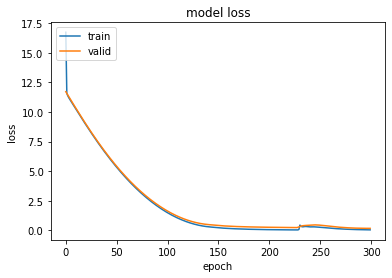

Units_100_l1_0.001_l2_0.005
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


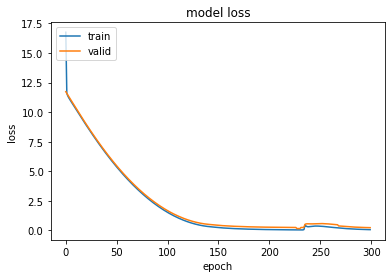

Units_100_l1_0.001_l2_0.005
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 53.84615384615385
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


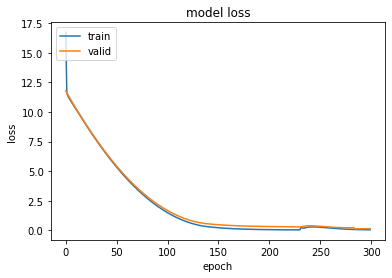

Units_100_l1_0.001_l2_0.005
Acc Train: 96.93877551020408
Acc Valid: 100.0
Acc Test: 69.23076923076923
AVG Score Train: [98.29931973  0.96598072]
AVG Score Valid: [93.93939394  0.87570621]
AVG Score Test: [64.1025641   0.29664586]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


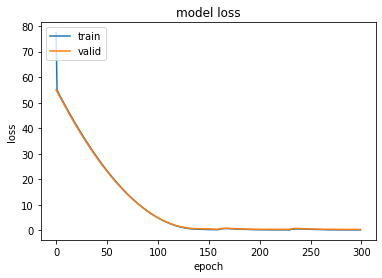

Units_100_l1_0.005_l2_0.0005
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


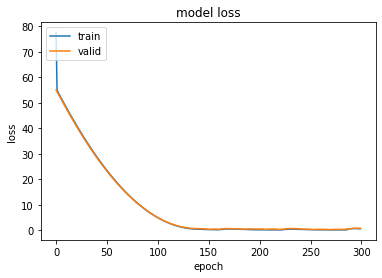

Units_100_l1_0.005_l2_0.0005
Acc Train: 86.73469387755102
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


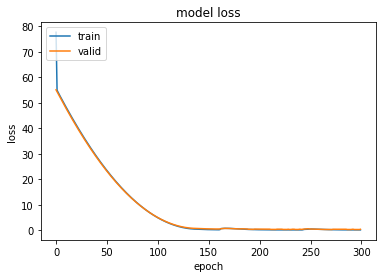

Units_100_l1_0.005_l2_0.0005
Acc Train: 78.57142857142857
Acc Valid: 100.0
Acc Test: 61.53846153846154
AVG Score Train: [88.0952381   0.76138608]
AVG Score Valid: [93.93939394  0.87570621]
AVG Score Test: [61.53846154  0.25820665]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


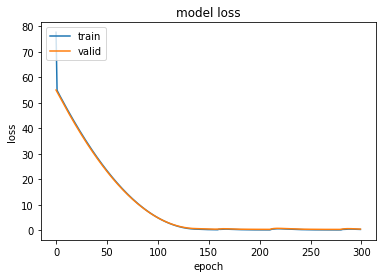

Units_100_l1_0.005_l2_0.001
Acc Train: 100.0
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


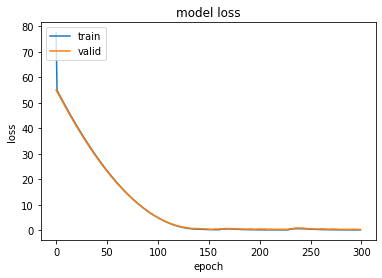

Units_100_l1_0.005_l2_0.001
Acc Train: 86.73469387755102
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


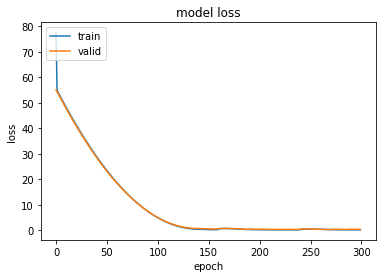

Units_100_l1_0.005_l2_0.001
Acc Train: 96.93877551020408
Acc Valid: 100.0
Acc Test: 69.23076923076923
AVG Score Train: [94.55782313  0.89063778]
AVG Score Valid: [93.93939394  0.87570621]
AVG Score Test: [64.1025641   0.30596177]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


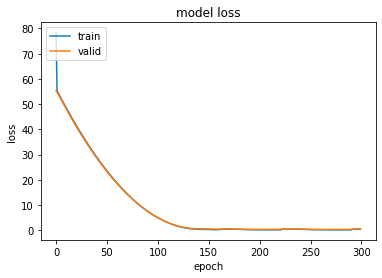

Units_100_l1_0.005_l2_0.005
Acc Train: 87.75510204081633
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


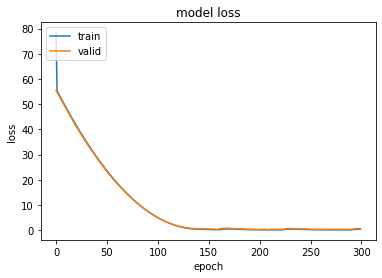

Units_100_l1_0.005_l2_0.005
Acc Train: 85.71428571428572
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


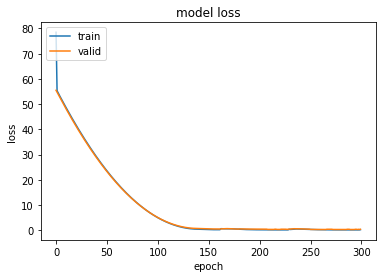

Units_100_l1_0.005_l2_0.005
Acc Train: 95.91836734693877
Acc Valid: 100.0
Acc Test: 61.53846153846154
AVG Score Train: [89.79591837  0.79531964]
AVG Score Valid: [93.93939394  0.87570621]
AVG Score Test: [64.1025641   0.30116296]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


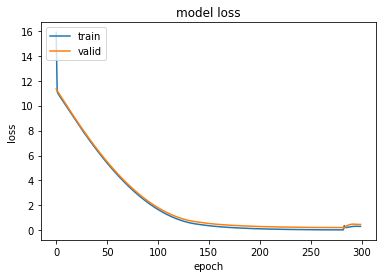

Units_200_l1_0.0005_l2_0.0005
Acc Train: 79.59183673469387
Acc Valid: 100.0
Acc Test: 69.23076923076923
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


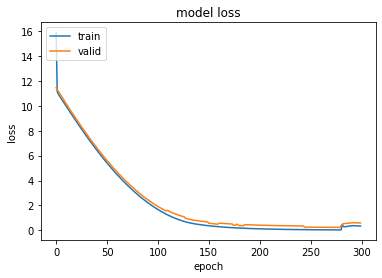

Units_200_l1_0.0005_l2_0.0005
Acc Train: 98.9795918367347
Acc Valid: 81.81818181818181
Acc Test: 61.53846153846154
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


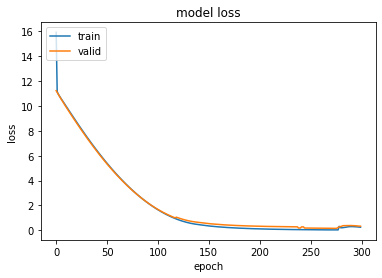

Units_200_l1_0.0005_l2_0.0005
Acc Train: 86.73469387755102
Acc Valid: 100.0
Acc Test: 38.46153846153846
AVG Score Train: [88.43537415  0.76870748]
AVG Score Valid: [93.93939394  0.86904762]
AVG Score Test: [56.41025641  0.14853074]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


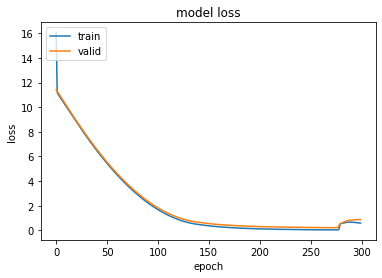

Units_200_l1_0.0005_l2_0.001
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


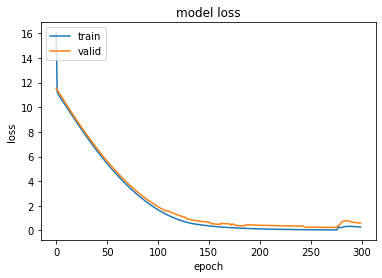

Units_200_l1_0.0005_l2_0.001
Acc Train: 98.9795918367347
Acc Valid: 81.81818181818181
Acc Test: 61.53846153846154
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


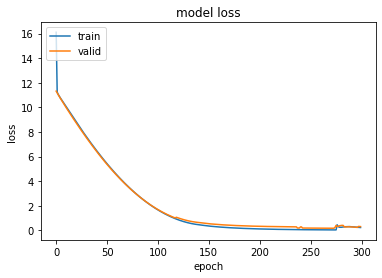

Units_200_l1_0.0005_l2_0.001
Acc Train: 85.71428571428572
Acc Valid: 100.0
Acc Test: 38.46153846153846
AVG Score Train: [94.55782313  0.89115646]
AVG Score Valid: [90.90909091  0.80690073]
AVG Score Test: [53.84615385  0.10501089]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


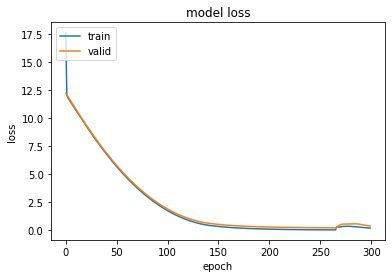

Units_200_l1_0.0005_l2_0.005
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


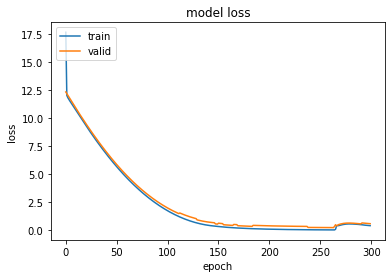

Units_200_l1_0.0005_l2_0.005
Acc Train: 97.95918367346938
Acc Valid: 81.81818181818181
Acc Test: 61.53846153846154
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


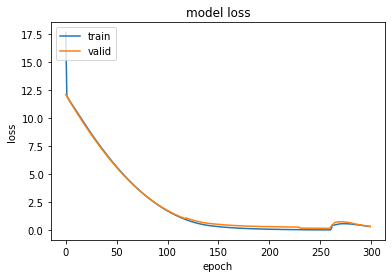

Units_200_l1_0.0005_l2_0.005
Acc Train: 85.71428571428572
Acc Valid: 100.0
Acc Test: 38.46153846153846
AVG Score Train: [94.21768707  0.88435941]
AVG Score Valid: [90.90909091  0.80690073]
AVG Score Test: [53.84615385  0.10501089]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


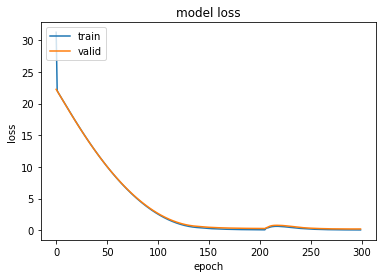

Units_200_l1_0.001_l2_0.0005
Acc Train: 94.89795918367348
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


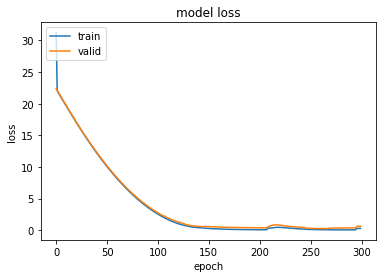

Units_200_l1_0.001_l2_0.0005
Acc Train: 94.89795918367348
Acc Valid: 81.81818181818181
Acc Test: 61.53846153846154
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


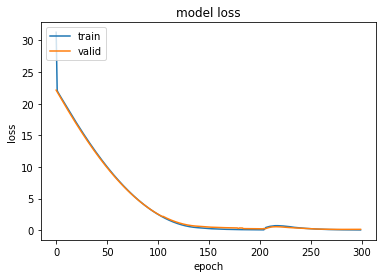

Units_200_l1_0.001_l2_0.0005
Acc Train: 84.6938775510204
Acc Valid: 100.0
Acc Test: 38.46153846153846
AVG Score Train: [91.49659864  0.82998854]
AVG Score Valid: [90.90909091  0.80690073]
AVG Score Test: [56.41025641  0.15356365]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


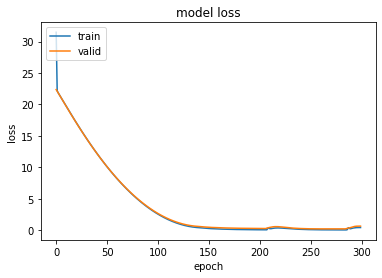

Units_200_l1_0.001_l2_0.001
Acc Train: 94.89795918367348
Acc Valid: 90.9090909090909
Acc Test: 61.53846153846154
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


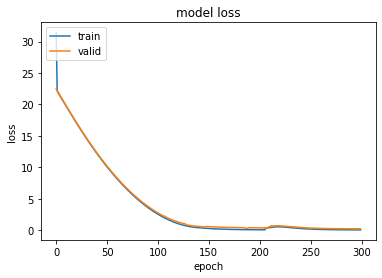

Units_200_l1_0.001_l2_0.001
Acc Train: 93.87755102040816
Acc Valid: 81.81818181818181
Acc Test: 61.53846153846154
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


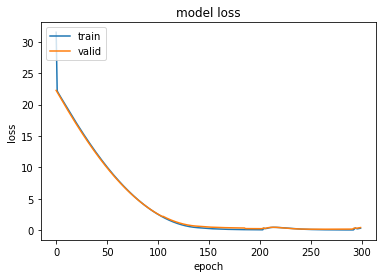

Units_200_l1_0.001_l2_0.001
Acc Train: 84.6938775510204
Acc Valid: 100.0
Acc Test: 38.46153846153846
AVG Score Train: [91.15646259  0.82321407]
AVG Score Valid: [90.90909091  0.80690073]
AVG Score Test: [53.84615385  0.10501089]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


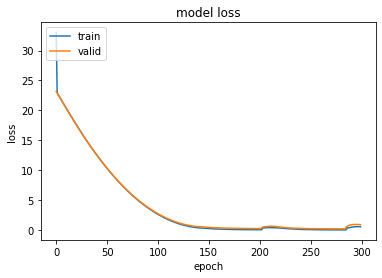

Units_200_l1_0.001_l2_0.005
Acc Train: 95.91836734693877
Acc Valid: 90.9090909090909
Acc Test: 53.84615384615385
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


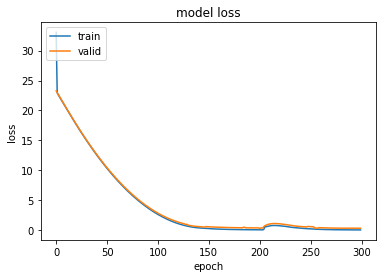

Units_200_l1_0.001_l2_0.005
Acc Train: 93.87755102040816
Acc Valid: 81.81818181818181
Acc Test: 61.53846153846154
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


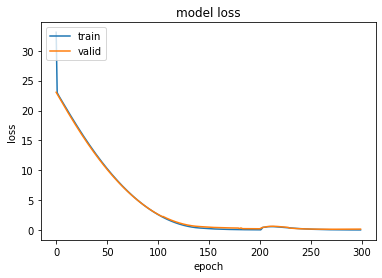

Units_200_l1_0.001_l2_0.005
Acc Train: 84.6938775510204
Acc Valid: 100.0
Acc Test: 38.46153846153846
AVG Score Train: [91.49659864  0.83001679]
AVG Score Valid: [90.90909091  0.80690073]
AVG Score Test: [5.12820513e+01 5.03890445e-02]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


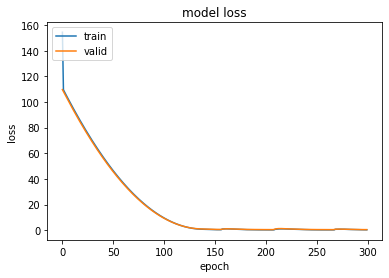

Units_200_l1_0.005_l2_0.0005
Acc Train: 82.6530612244898
Acc Valid: 90.9090909090909
Acc Test: 76.92307692307692
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


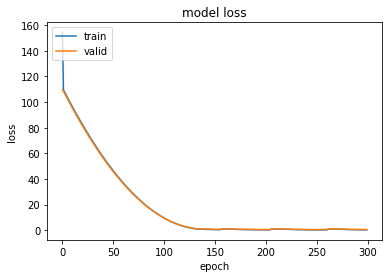

Units_200_l1_0.005_l2_0.0005
Acc Train: 62.244897959183675
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


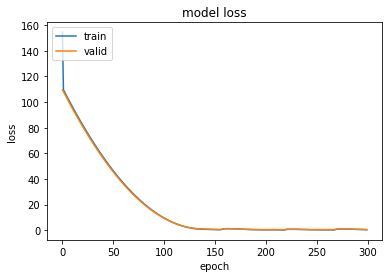

Units_200_l1_0.005_l2_0.0005
Acc Train: 90.81632653061224
Acc Valid: 100.0
Acc Test: 53.84615384615385
AVG Score Train: [78.57142857  0.57309477]
AVG Score Valid: [93.93939394  0.86867072]
AVG Score Test: [66.66666667  0.33653683]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


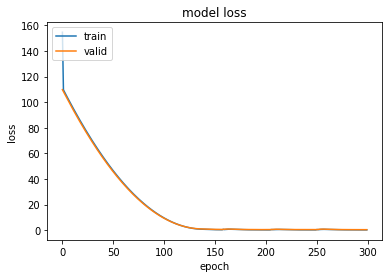

Units_200_l1_0.005_l2_0.001
Acc Train: 100.0
Acc Valid: 90.9090909090909
Acc Test: 53.84615384615385
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


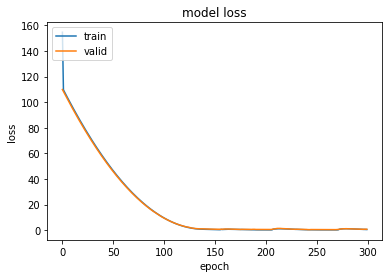

Units_200_l1_0.005_l2_0.001
Acc Train: 96.93877551020408
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


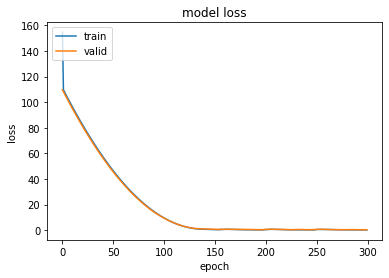

Units_200_l1_0.005_l2_0.001
Acc Train: 90.81632653061224
Acc Valid: 100.0
Acc Test: 53.84615384615385
AVG Score Train: [95.91836735  0.91838433]
AVG Score Valid: [93.93939394  0.86867072]
AVG Score Test: [58.97435897  0.1859219 ]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


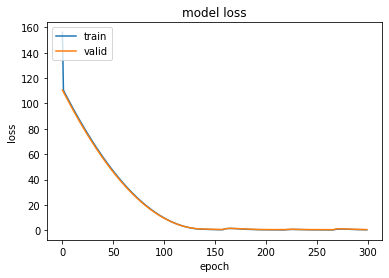

Units_200_l1_0.005_l2_0.005
Acc Train: 86.73469387755102
Acc Valid: 90.9090909090909
Acc Test: 76.92307692307692
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


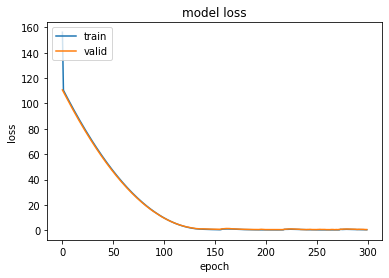

Units_200_l1_0.005_l2_0.005
Acc Train: 75.51020408163265
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


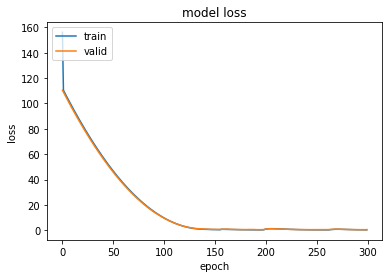

Units_200_l1_0.005_l2_0.005
Acc Train: 90.81632653061224
Acc Valid: 100.0
Acc Test: 53.84615384615385
AVG Score Train: [84.3537415   0.68808848]
AVG Score Valid: [93.93939394  0.86867072]
AVG Score Test: [66.66666667  0.34156974]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


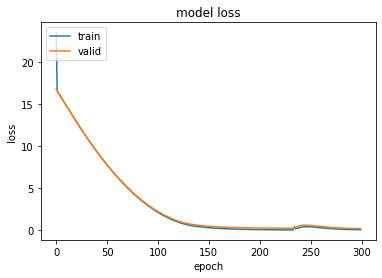

Units_300_l1_0.0005_l2_0.0005
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


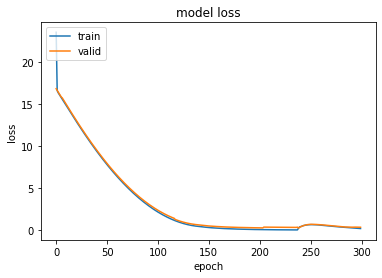

Units_300_l1_0.0005_l2_0.0005
Acc Train: 98.9795918367347
Acc Valid: 81.81818181818181
Acc Test: 69.23076923076923
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


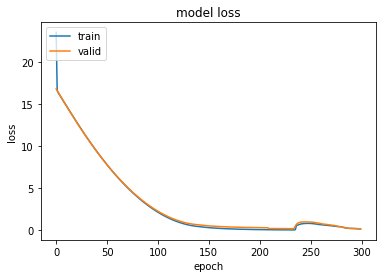

Units_300_l1_0.0005_l2_0.0005
Acc Train: 94.89795918367348
Acc Valid: 100.0
Acc Test: 69.23076923076923
AVG Score Train: [97.61904762  0.95238095]
AVG Score Valid: [90.90909091  0.80690073]
AVG Score Test: [69.23076923  0.3857512 ]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


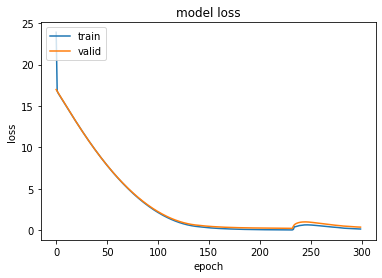

Units_300_l1_0.0005_l2_0.001
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


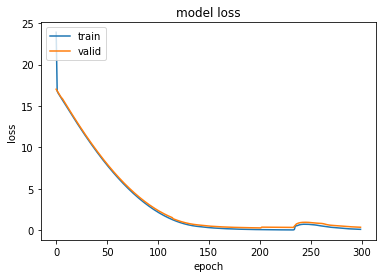

Units_300_l1_0.0005_l2_0.001
Acc Train: 98.9795918367347
Acc Valid: 81.81818181818181
Acc Test: 69.23076923076923
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


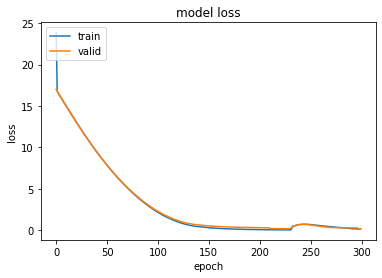

Units_300_l1_0.0005_l2_0.001
Acc Train: 100.0
Acc Valid: 100.0
Acc Test: 61.53846153846154
AVG Score Train: [99.31972789  0.98639456]
AVG Score Valid: [90.90909091  0.80690073]
AVG Score Test: [66.66666667  0.33239963]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


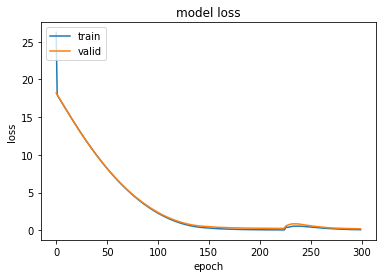

Units_300_l1_0.0005_l2_0.005
Acc Train: 94.89795918367348
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


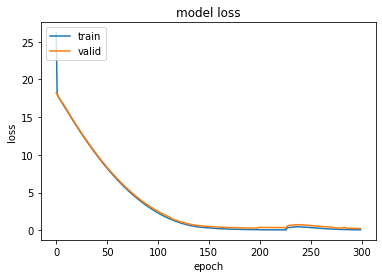

Units_300_l1_0.0005_l2_0.005
Acc Train: 97.95918367346938
Acc Valid: 81.81818181818181
Acc Test: 69.23076923076923
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


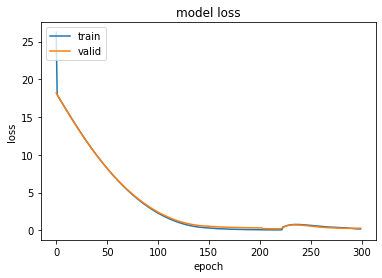

Units_300_l1_0.0005_l2_0.005
Acc Train: 92.85714285714286
Acc Valid: 90.9090909090909
Acc Test: 53.84615384615385
AVG Score Train: [95.23809524  0.90476757]
AVG Score Valid: [87.87878788  0.74679144]
AVG Score Test: [64.1025641   0.29184704]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


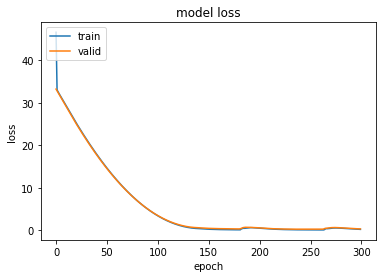

Units_300_l1_0.001_l2_0.0005
Acc Train: 94.89795918367348
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


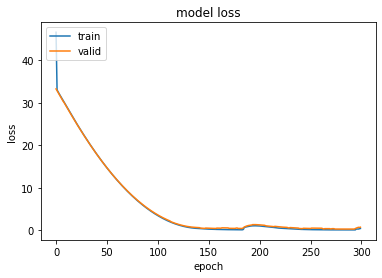

Units_300_l1_0.001_l2_0.0005
Acc Train: 85.71428571428572
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


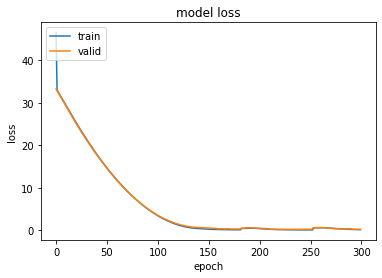

Units_300_l1_0.001_l2_0.0005
Acc Train: 100.0
Acc Valid: 100.0
Acc Test: 69.23076923076923
AVG Score Train: [93.53741497  0.87126118]
AVG Score Valid: [93.93939394  0.86867072]
AVG Score Test: [69.23076923  0.3857512 ]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


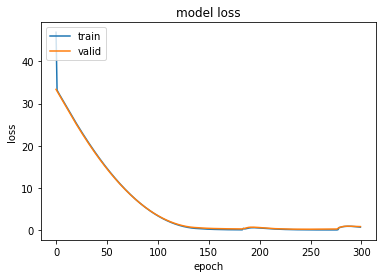

Units_300_l1_0.001_l2_0.001
Acc Train: 94.89795918367348
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


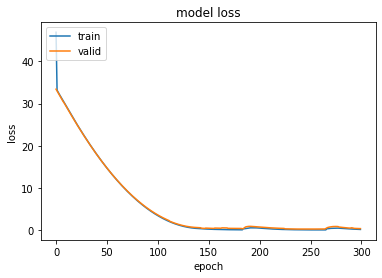

Units_300_l1_0.001_l2_0.001
Acc Train: 84.6938775510204
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


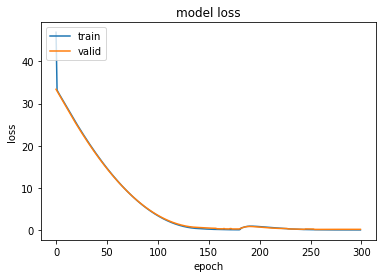

Units_300_l1_0.001_l2_0.001
Acc Train: 92.85714285714286
Acc Valid: 100.0
Acc Test: 69.23076923076923
AVG Score Train: [90.81632653  0.81691807]
AVG Score Valid: [93.93939394  0.86867072]
AVG Score Test: [69.23076923  0.38095238]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


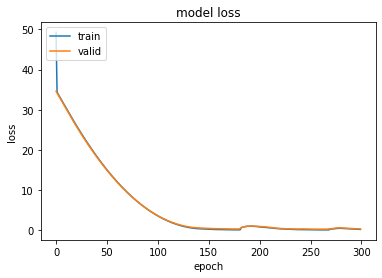

Units_300_l1_0.001_l2_0.005
Acc Train: 93.87755102040816
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


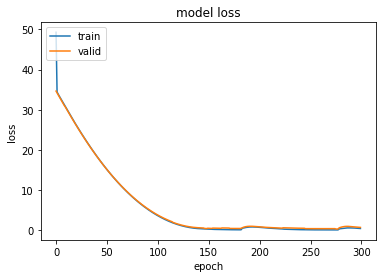

Units_300_l1_0.001_l2_0.005
Acc Train: 80.61224489795919
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


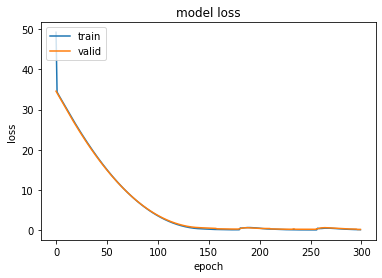

Units_300_l1_0.001_l2_0.005
Acc Train: 98.9795918367347
Acc Valid: 100.0
Acc Test: 61.53846153846154
AVG Score Train: [91.15646259  0.82409103]
AVG Score Valid: [93.93939394  0.86867072]
AVG Score Test: [66.66666667  0.33239963]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


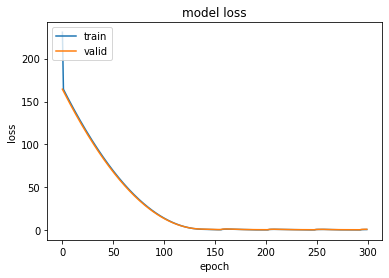

Units_300_l1_0.005_l2_0.0005
Acc Train: 98.9795918367347
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


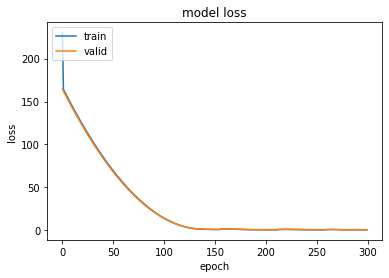

Units_300_l1_0.005_l2_0.0005
Acc Train: 94.89795918367348
Acc Valid: 90.9090909090909
Acc Test: 53.84615384615385
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


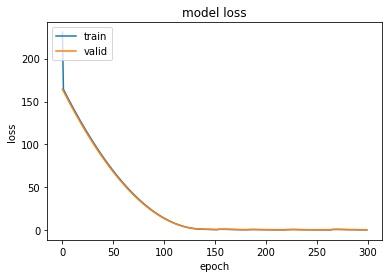

Units_300_l1_0.005_l2_0.0005
Acc Train: 96.93877551020408
Acc Valid: 100.0
Acc Test: 69.23076923076923
AVG Score Train: [96.93877551  0.93880382]
AVG Score Valid: [93.93939394  0.86867072]
AVG Score Test: [64.1025641  0.2799431]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


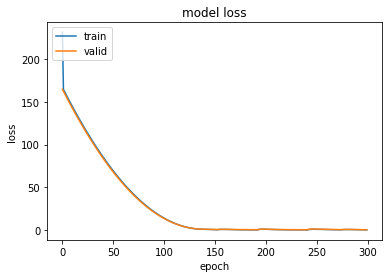

Units_300_l1_0.005_l2_0.001
Acc Train: 92.85714285714286
Acc Valid: 90.9090909090909
Acc Test: 46.15384615384615
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


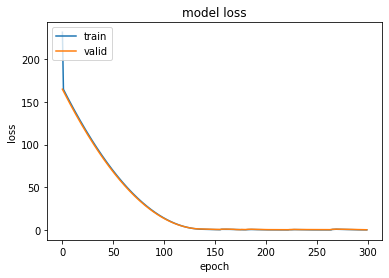

Units_300_l1_0.005_l2_0.001
Acc Train: 100.0
Acc Valid: 90.9090909090909
Acc Test: 53.84615384615385
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


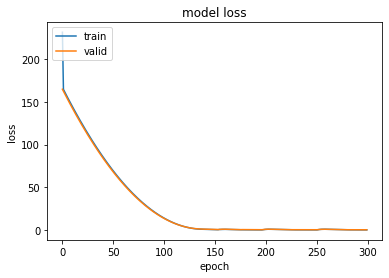

Units_300_l1_0.005_l2_0.001
Acc Train: 94.89795918367348
Acc Valid: 100.0
Acc Test: 61.53846153846154
AVG Score Train: [95.91836735  0.91836735]
AVG Score Valid: [93.93939394  0.87070832]
AVG Score Test: [53.84615385  0.09411345]
Fold: 1
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


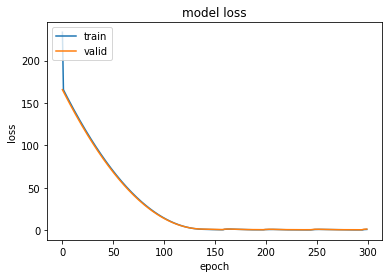

Units_300_l1_0.005_l2_0.005
Acc Train: 92.85714285714286
Acc Valid: 90.9090909090909
Acc Test: 46.15384615384615
Fold: 2
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


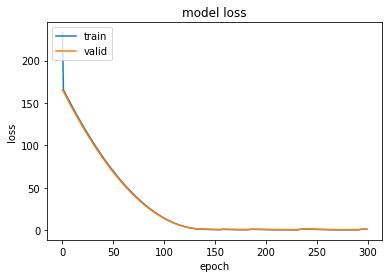

Units_300_l1_0.005_l2_0.005
Acc Train: 62.244897959183675
Acc Valid: 90.9090909090909
Acc Test: 69.23076923076923
Fold: 3
Train (98, 40, 40, 1) (98, 2)
Valid (11, 40, 40, 1) (11, 2)
Test (13, 40, 40, 1) (13, 2)


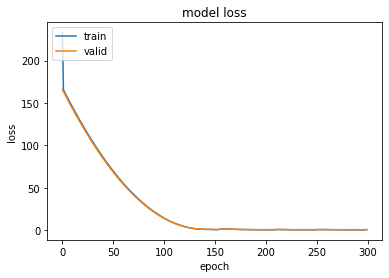

Units_300_l1_0.005_l2_0.005
Acc Train: 90.81632653061224
Acc Valid: 100.0
Acc Test: 61.53846153846154
AVG Score Train: [81.97278912  0.64049975]
AVG Score Valid: [93.93939394  0.87774382]
AVG Score Test: [58.97435897  0.18563218]
CNN train/validation Done!!!



In [ ]:
# Some initial parameters-------------------------------------------------------
sbj           = 30                             # subject id
n_fb          = 2                              # 0 --> 8-12Hz, 1--->12-30Hz
num_classes   = 2                              # num of classes
n_filt        = 2                              # number of CNN filters
n_unit        = [100,200,300]                  # number of hidden units in hidden layer
learning_rate = 1e-4                           # learning rate value
l1_param      = [0.0005,0.001,0.005]           # l_1 regularization param
l2_param      = [0.0005,0.001,0.005]           # L_2 regularization param
Ntw           = 5                              # number of time windows
Nkfeats       = 2                              # number of feat types
nflds         = 3                              # number of folds 
#-------------------------------------------------------------------------------
# load data train/test trough all tw
th_name  = np.array([[-1.5, 0.5],[-0.5, 1.5],[0.5, 2.5],[1.5, 3.5],[2.5, 4.5]]) # considered time-windows
XF_train_cwt = []
XF_train_csp = []
XF_test_cwt  = []
XF_test_csp  = []
for i in range(th_name.shape[0]):
  X_train_re_cwt, X_train_re_csp, X_test_re_cwt, X_test_re_csp, y_trainF, y_testF = TW_data(sbj,th_name[i,0],th_name[i,1])
  XF_train_cwt.append(X_train_re_cwt)
  XF_train_csp.append(X_train_re_csp)
  XF_test_cwt.append(X_test_re_cwt)
  XF_test_csp.append(X_test_re_csp)
#-------------------------------------------------------------------------------
AccTrain      = []    # store variable of train acc
AccValid      = []    # store variable of valid acc
AccTest       = []    # store variable of test acc
for hu in range(len(n_unit)):# loop across number of units
  for l1_p in range(len(l1_param)):# loop across l1 param
      for l2_p in range(len(l2_param)):# loop across l2 param
        ScoreTrain = []
        ScoreValid = []
        ScoreTest  = []
        for fld in range(nflds):
          print('Fold:',fld+1)
          # adjust data
          XT_train, XT_valid, XT_test, y_train, y_valid, y_test, train_index, valid_index = norm_data(XF_train_cwt, XF_train_csp, XF_test_cwt, XF_test_csp, n_fb, Ntw, y_trainF, y_testF, fld)
          print('Train', XT_train[0].shape,y_train.shape)
          print('Valid', XT_valid[0].shape,y_valid.shape)
          print('Test', XT_test[0].shape,y_test.shape)
          #---------------------------------------------------------------------
          with open('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/train_valid_idxs/tr_vld_idxs_sbj_'+str(sbj)+'_fld_'+str(fld+1)+'.pickle', 'wb') as f:
            pickle.dump([train_index, valid_index], f)
          #---------------------------------------------------------------------
          # define cnn network
          model = cnn_network(n_fb,Nkfeats,Ntw,40,n_filt,n_unit[hu],l1_param[l1_p],l2_param[l2_p],learning_rate,sbj)
          #---------------------------------------------------------------------
          # checkpoint
          filepath   ='/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/parameter_setting/weights_sbj_'+str(sbj)+'_filters_'+str(n_filt)+'_units_'+str(n_unit[hu])+'_l1_'+str(l1_param[l1_p])+'_l2_'+str(l2_param[l2_p])+'_fld_'+str(fld+1)+'.hdf5'
          checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
          #---------------------------------------------------------------------
          # Fit the CNN model
          history = model.fit(XT_train, y_train, 
                              epochs=300, 
                              batch_size=256, 
                              validation_data=(XT_valid,y_valid),
                              callbacks=[checkpoint, keras.callbacks.EarlyStopping(patience=200,restore_best_weights=True)],verbose=0)
          #---------------------------------------------------------------------
          # load model with best params
          model.load_weights(filepath)
          #---------------------------------------------------------------------
          # plot loss performance    
          plt.plot(history.history['loss'])
          plt.plot(history.history['val_loss'])
          plt.title('model loss')
          plt.ylabel('loss')
          plt.xlabel('epoch')
          plt.legend(['train', 'valid'], loc='upper left')
          plt.show()
          with open('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/parameter_setting/tr_vld_loss_sbj_'+str(sbj)+'_units_'+str(n_unit[hu])+'_l1_'+str(l1_param[l1_p])+'_l2_'+str(l2_param[l2_p])+'_fld_'+str(fld+1)+'.pickle', 'wb') as f:
            pickle.dump([history.history['loss'], history.history['val_loss']], f)
          #---------------------------------------------------------------------
          # Predict model and scores
          # train
          y_train_pred = model.predict(XT_train)
          y_train_pred = np.argmax(y_train_pred, axis=1)
          y_train1     = np.argmax(y_train,axis=1)
          acc_train    = 1-mean_squared_error(y_train1,y_train_pred)
          kappa_train  = cohen_kappa_score(y_train1, y_train_pred, labels=None, weights=None)
          # validation
          y_valid_pred = model.predict(XT_valid)
          y_valid_pred = np.argmax(y_valid_pred, axis=1)
          y_valid1     = np.argmax(y_valid,axis=1)
          acc_valid    = 1-mean_squared_error(y_valid1,y_valid_pred)
          kappa_valid  = cohen_kappa_score(y_valid1, y_valid_pred, labels=None, weights=None)
          # test   
          y_test_pred = model.predict(XT_test)
          y_test_pred = np.argmax(y_test_pred, axis=1)
          y_test1     = np.argmax(y_test,axis=1)
          acc_test    = 1-mean_squared_error(y_test1,y_test_pred)
          kappa_test  = cohen_kappa_score(y_test1, y_test_pred, labels=None, weights=None)
          #---------------------------------------------------------------------
          print('Units_'+str(n_unit[hu])+'_l1_'+str(l1_param[l1_p])+'_l2_'+str(l2_param[l2_p]))
          print('Acc Train:', acc_train*100)
          print('Acc Valid:', acc_valid*100)
          print('Acc Test:', acc_test*100)
          #---------------------------------------------------------------------
          # append scores per flds
          ScoreTrain.append([acc_train*100,kappa_train])
          ScoreValid.append([acc_valid*100,kappa_valid])
          ScoreTest.append([acc_test*100,kappa_test])
          #---------------------------------------------------------------------
          del model
        #-----------------------------------------------------------------------
        # append avg scores
        print('AVG Score Train:',np.mean(np.array(ScoreTrain),axis=0))
        print('AVG Score Valid:',np.mean(np.array(ScoreValid),axis=0))
        print('AVG Score Test:',np.mean(np.array(ScoreTest),axis=0))
        AccTrain.append([n_unit[hu],l1_param[l1_p],l2_param[l2_p],np.mean(np.array(ScoreTrain),axis=0)[0],np.std(np.array(ScoreTrain),axis=0)[0],np.mean(np.array(ScoreTrain),axis=0)[1],np.std(np.array(ScoreTrain),axis=0)[1]])
        AccValid.append([n_unit[hu],l1_param[l1_p],l2_param[l2_p],np.mean(np.array(ScoreValid),axis=0)[0],np.std(np.array(ScoreValid),axis=0)[0],np.mean(np.array(ScoreValid),axis=0)[1],np.std(np.array(ScoreValid),axis=0)[1]])
        AccTest.append([n_unit[hu],l1_param[l1_p],l2_param[l2_p],np.mean(np.array(ScoreTest),axis=0)[0],np.std(np.array(ScoreTest),axis=0)[0],np.mean(np.array(ScoreTest),axis=0)[1],np.std(np.array(ScoreTest),axis=0)[1]])
#-------------------------------------------------------------------------------
# save results per folds
with open('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/scores/Scores_train_sbj_'+str(sbj)+'.pickle', 'wb') as f:
  pickle.dump(AccTrain, f)
with open('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/scores/Scores_valid_sbj_'+str(sbj)+'.pickle', 'wb') as f:
  pickle.dump(AccValid, f)
with open('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/scores/Scores_test_sbj_'+str(sbj)+'.pickle', 'wb') as f:
  pickle.dump(AccTest, f)
#-------------------------------------------------------------------------------
print('CNN train/validation Done!!!\n')
#-------------------------------------------------------------------------------

# Quantitative results (best parameters)

In [ ]:
#-------------------------------------------------------------------------------
# definition
#-------------------------------------------------------------------------------
def min_dist(X):
    p1       = [100.0,0.0]
    distance = []
    for i in range(len(X)):
        p2 = X[i,:]
        distance.append(math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) ))
    min_id = np.argmin(distance) 
    return distance, min_id
#-------------------------------------------------------------------------------

In [ ]:
#-------------------------------------------------------------------------------
# show quantitative results
num_classes = 2
print('Subject '+str(sbj))
# load result data--------------------------------------------------------------
with open('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/scores/Scores_test_sbj_'+str(sbj)+'.pickle', 'rb') as f:
  scores_test_data = pickle.load(f)
scores_test_data = np.array(scores_test_data)
X = scores_test_data[:,-4:-2]
print(X)
#-------------------------------------------------------------------------------    
# select best performance-------------------------------------------------------
distance, min_id = min_dist(X)
max_id           = min_id
opt_neurons      = scores_test_data[max_id,scores_test_data.shape[1]-7]
opt_l1           = scores_test_data[max_id,scores_test_data.shape[1]-6]
opt_l2           = scores_test_data[max_id,scores_test_data.shape[1]-5]
print('Subject '+str(sbj)+ '- acc: ' +str(X[max_id,0])+'+/-'+str(X[max_id,1])+' - Kappa value: '+str(scores_test_data[max_id,-2])+'+/-'+str(scores_test_data[max_id,-1])+
      ' neurons '+str(int(opt_neurons))+ ' l1_val '+str(opt_l1)+ ' l2_val '+str(opt_l2))
#-------------------------------------------------------------------------------

Subject 30
[[58.97435897  3.62618862]
 [58.97435897  3.62618862]
 [58.97435897  3.62618862]
 [64.1025641   9.5939933 ]
 [64.1025641   9.5939933 ]
 [64.1025641   7.25237724]
 [61.53846154  0.        ]
 [64.1025641   3.62618862]
 [64.1025641   3.62618862]
 [56.41025641 13.07440901]
 [53.84615385 10.87856586]
 [53.84615385 10.87856586]
 [56.41025641 13.07440901]
 [53.84615385 10.87856586]
 [51.28205128  9.5939933 ]
 [66.66666667  9.5939933 ]
 [58.97435897  7.25237724]
 [66.66666667  9.5939933 ]
 [69.23076923  0.        ]
 [66.66666667  3.62618862]
 [64.1025641   7.25237724]
 [69.23076923  0.        ]
 [69.23076923  0.        ]
 [66.66666667  3.62618862]
 [64.1025641   7.25237724]
 [53.84615385  6.28074293]
 [58.97435897  9.5939933 ]]
Subject 30- acc: 69.23076923076923+/-0.0 - Kappa value: 0.385751199704688+/-0.006786554562883044 neurons 300 l1_val 0.0005 l2_val 0.0005


# Qualitative results (relevance analysis)

In [ ]:
#-------------------------------------------------------------------------------
def hidden_layer_results(hidden_layer,shape_im):
    weights, biases = hidden_layer.get_weights()    
    tmp0            = np.sum(np.abs(weights),axis=1)
    n_filters       = np.int(tmp0.shape[0]/(shape_im[0]*shape_im[1]))
    im              = [] 
    for i in range(n_filters):
        image = []
        j     = 0 + i
        while j < tmp0.shape[0]:
            image.append(tmp0[j])
            j = j+(n_filters)
        image = np.array(image)
        im.append(image.reshape((shape_im)))
    im  = np.array(im)
    # average across kernel filters
    vec_t = np.arange(0,im.shape[0],2)
    imF   = []
    for l in range(len(vec_t)):
        if l == len(vec_t)-1:
            imF.append(np.mean(im[vec_t[l]:im.shape[0],:,:],axis=0))
        else:
            imF.append(np.mean(im[vec_t[l]:vec_t[l+1],:,:],axis=0))
    imF = np.array(imF)
    return imF
#-------------------------------------------------------------------------------

Subject 30
[0, 1, 10, 11]
[2, 3, 12, 13]
[4, 5, 14, 15]
[6, 7, 16, 17]
[8, 9, 18, 19]
max_val 0.7473666
new_max_val 1.0
min_val 0.081493825
[0, 1, 10, 11]
[2, 3, 12, 13]
[4, 5, 14, 15]
[6, 7, 16, 17]
[8, 9, 18, 19]
max_val 0.6986233
new_max_val 1.0
min_val 0.060913775
[0, 1, 10, 11]
[2, 3, 12, 13]
[4, 5, 14, 15]
[6, 7, 16, 17]
[8, 9, 18, 19]
max_val 0.23532148
new_max_val 1.0
min_val 0.013540557


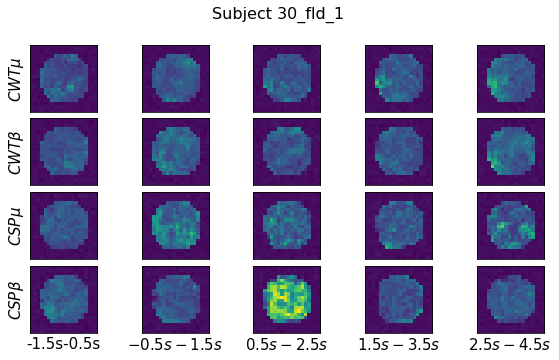

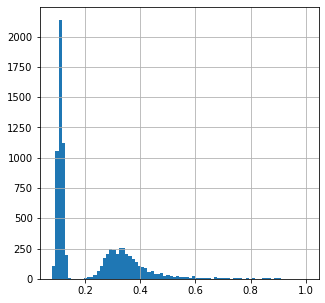

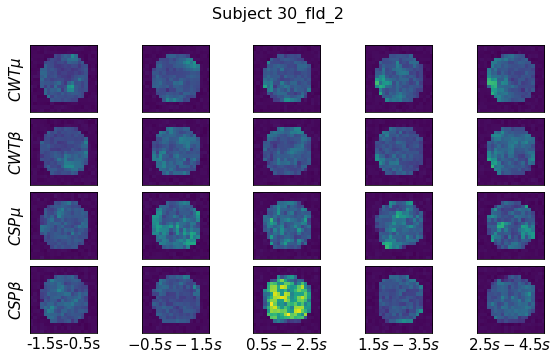

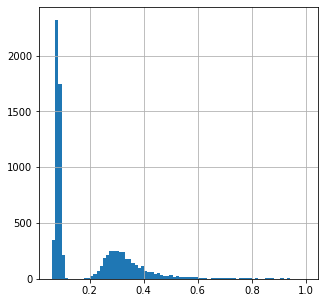

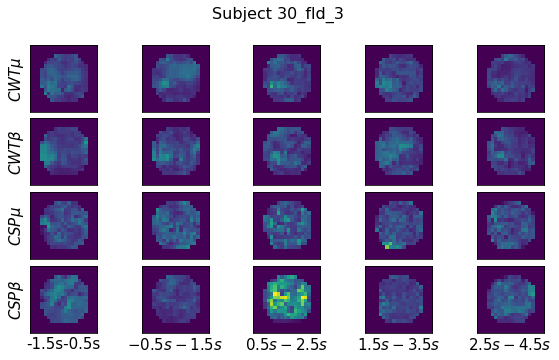

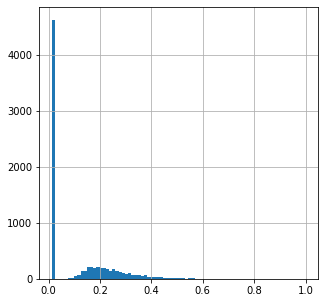

In [ ]:
#-------------------------------------------------------------------------------
names_x  = [r'-1.5s-0.5s',r'$-0.5s-1.5s$',r'$0.5s-2.5s$',r'$1.5s-3.5s$',r'$2.5s-4.5s$']
print('Subject '+str(sbj))
# Describe CNN model------------------------------------------------------------
model = cnn_network(n_fb,Nkfeats,Ntw,40,n_filt,opt_neurons,opt_l1,opt_l2,learning_rate,sbj)
#-------------------------------------------------------------------------------
# plot topographic maps---------------------------------------------------------
for fld in range(nflds):
  hist            = []
  topo_avg_mu_cwt = []
  topo_avg_be_cwt = []
  topo_avg_mu_csp = []
  topo_avg_be_csp = []
  #-----------------------------------------------------------------------------
  # figure plot setting---------------------------------------------------------
  fig, axs = plt.subplots(4,5,figsize=(10,5.3))
  fig.subplots_adjust(hspace = 0.1, wspace=.0001)
  #-----------------------------------------------------------------------------
  filepath        = '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/parameter_setting/weights_sbj_'+str(sbj)+'_filters_2_units_'+str(int(opt_neurons))+'_l1_'+str(opt_l1)+'_l2_'+str(opt_l2)+'_fld_'+str(fld+1)+'.hdf5'
  checkpoint_path = filepath
  model.load_weights(checkpoint_path)
  #-----------------------------------------------------------------------------
  # Hidden layer results--------------------------------------------------------
  hidden_layer = model.layers[83]
  shape_im     = model.layers[79].output_shape[1:3]
  im_mean      = hidden_layer_results(hidden_layer,shape_im)
  #-----------------------------------------------------------------------------    

  for tw in range(Ntw):
    if tw == 0:
      ids_tw = [tw, tw+1, tw+10, tw+10+1] 
    else:
      ids_tw = [tw*2, tw*2+1, tw*2+10, tw*2+10+1]
    print(ids_tw)
    XT_mu_cwt = []
    XT_be_cwt = []
    XT_mu_csp = []
    XT_be_csp = []
    #---------------------------------------------------------------------------
    # standarsize and normalize
    x_mu_cwt   = np.array(im_mean[ids_tw[0],:,:])
    x_beta_cwt = np.array(im_mean[ids_tw[1],:,:])
    x_mu_csp   = np.array(im_mean[ids_tw[2],:,:])
    x_beta_csp = np.array(im_mean[ids_tw[3],:,:])
    #---------------------------------------------------------------------------
    topo_avg_mu_cwt.append(np.array(x_mu_cwt))
    topo_avg_be_cwt.append(np.array(x_beta_cwt))
    topo_avg_mu_csp.append(np.array(x_mu_csp))
    topo_avg_be_csp.append(np.array(x_beta_csp))
    #---------------------------------------------------------------------------
  topo_avg_muT_cwt = np.array(topo_avg_mu_cwt)
  topo_avg_beT_cwt = np.array(topo_avg_be_cwt)
  topo_avg_muT_csp = np.array(topo_avg_mu_csp)
  topo_avg_beT_csp = np.array(topo_avg_be_csp)
  #-----------------------------------------------------------------------------
  max_val = max(topo_avg_muT_cwt.max(),topo_avg_beT_cwt.max(),topo_avg_muT_csp.max(),topo_avg_beT_csp.max())
  print('max_val',max_val)
  #-----------------------------------------------------------------------------
  topo_avg_muT_cwt = topo_avg_muT_cwt / max_val 
  topo_avg_beT_cwt = topo_avg_beT_cwt / max_val 
  topo_avg_muT_csp = topo_avg_muT_csp / max_val 
  topo_avg_beT_csp = topo_avg_beT_csp / max_val
  #-----------------------------------------------------------------------------
  max_val = max(topo_avg_muT_cwt.max(),topo_avg_beT_cwt.max(),topo_avg_muT_csp.max(),topo_avg_beT_csp.max())
  print('new_max_val',max_val)
  #-----------------------------------------------------------------------------
  min_val = min(topo_avg_muT_cwt.min(),topo_avg_beT_cwt.min(),topo_avg_muT_csp.min(),topo_avg_beT_csp.min())
  print('min_val',min_val)
  #-----------------------------------------------------------------------------
  with open('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/matrix_data/WeightsRel_sbj_'+str(sbj)+'_fold_'+str(fld+1)+'.pickle', 'wb') as f:
    pickle.dump([topo_avg_muT_cwt,topo_avg_beT_cwt,topo_avg_muT_csp,topo_avg_beT_csp], f)
  #-----------------------------------------------------------------------------
  for vnt in range(Ntw):
      axs[0,vnt].imshow(topo_avg_muT_cwt[vnt,:,:],vmin=min_val, vmax=max_val)
      axs[1,vnt].imshow(topo_avg_beT_cwt[vnt,:,:],vmin=min_val, vmax=max_val)
      axs[2,vnt].imshow(topo_avg_muT_csp[vnt,:,:],vmin=min_val, vmax=max_val)
      axs[3,vnt].imshow(topo_avg_beT_csp[vnt,:,:],vmin=min_val, vmax=max_val)
      axs[3,vnt].set(xlabel=names_x[vnt])
      axs[3,vnt].xaxis.get_label().set_fontsize(15)
      if vnt == 0:
        axs[0,vnt].set(ylabel=r'$CWT \mu$')
        axs[0,vnt].yaxis.get_label().set_fontsize(15)
        axs[1,vnt].set(ylabel=r'$CWT \beta$')
        axs[1,vnt].yaxis.get_label().set_fontsize(15)
        axs[2,vnt].set(ylabel=r'$CSP \mu$')
        axs[2,vnt].yaxis.get_label().set_fontsize(15)
        axs[3,vnt].set(ylabel=r'$CSP \beta$')
        axs[3,vnt].yaxis.get_label().set_fontsize(15)
      fig.suptitle('Subject '+str(sbj)+'_fld_'+str(fld+1), fontsize=16)

      # hist
      hist.append(topo_avg_muT_cwt[vnt,:,:].flatten())
      hist.append(topo_avg_beT_cwt[vnt,:,:].flatten())
      hist.append(topo_avg_muT_csp[vnt,:,:].flatten())
      hist.append(topo_avg_beT_csp[vnt,:,:].flatten())
  #-----------------------------------------------------------------------------
  for ax in axs.flat:
      ax.label_outer()
  for ax in axs.flat:
      ax.set_xticks([])
      ax.set_yticks([])
      plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/images/Topoplots_Subject_'+str(sbj)+'_fld_'+str(fld+1)+'.svg', format='svg')
  #-----------------------------------------------------------------------------
  #plot histograms
  hist = np.concatenate(hist)
  hist = hist.flatten()
  plt.figure(figsize=(5,5))
  plt.hist(hist,bins=80)
  plt.grid()
  #-----------------------------------------------------------------------------

In [ ]:
print('Subject '+str(sbj)+ '- acc: ' +str(X[max_id,0])+'+/-'+str(X[max_id,1])+' - Kappa value: '+str(scores_test_data[max_id,-2])+'+/-'+str(scores_test_data[max_id,-1])+
      ' neurons '+str(int(opt_neurons))+ ' l1_val '+str(opt_l1)+ ' l2_val '+str(opt_l2))

Subject 30- acc: 69.23076923076923+/-0.0 - Kappa value: 0.385751199704688+/-0.006786554562883044 neurons 300 l1_val 0.0005 l2_val 0.0005


# Download data

In [ ]:
#from google.colab import files
#files.download('/content/parameter_setting/weights_sbj_'+str(sbj)+'_filters_'+str(n_filt)+'_units_'+str(int(opt_neurons))+'_l1_'+str(opt_l1)+'_l2_'+str(opt_l2)+'.hdf5') 

In [ ]:
#from google.colab import files
#files.download('/content/parameter_setting/tr_vld_loss_sbj_'+str(sbj)+'_units_'+str(int(opt_neurons))+'_l1_'+str(opt_l1)+'_l2_'+str(opt_l2)+'.pickle') 

In [ ]:
#from google.colab import files
#files.download('/content/train_valid_idxs/tr_vld_idxs_sbj_'+str(sbj)+'.pickle') 

In [ ]:
#from google.colab import files
#files.download('/content/results/Topoplots_Subject_'+str(Nsbj)+'T.svg') 